# Risk Adjustment and Machine Learning

Carreta ilustrada

### Loading health data

In [1]:
# Import pandas and assign to it the pd alias
import pandas as pd

# Load csv to pd.dataframe using pd.read_csv
df_salud = pd.read_csv('../suficiencia.csv')

# Index is not appropiately set
print(df_salud.head())

# pd.read_csv inferred unconvenient data types for some columns
for columna in df_salud.columns:
    print(columna,df_salud[columna].dtype)

                                NUM_IDE  FECHA_NACI SEXO  MUNI_2010  \
0  00000194-D058-45CA-8FFA-104DC5EEFFFB  1990-02-22    F          1   
1  0000044A-6B61-4EBF-BF51-CCFE020AF4C7  1935-07-15    M          1   
2  00000495-E581-4053-A710-6275911EF9AB  1964-05-23    M          1   
3  000007D9-9087-4F36-9B26-25D205C46EE1  1974-10-06    M        430   
4  00000CF1-F4ED-4330-8739-C82FCF1BCAC7  2000-12-28    M        172   

   MUNI_2011  DPTO_2010  DPTO_2011 EPS_2010 EPS_2011  DIAS_COMP_2010  \
0          1         11         11   EPS008   EPS008             150   
1          1          8          8   EPS037   EPS037             360   
2          1         54         54   EPS037   EPS037             360   
3        430         25         25   EPS013   EPS013             191   
4         88          5          5   EPS013   EPS013             180   

     ...      DIAG_1_W_2011  DIAG_1_X_2011  DIAG_1_Y_2011  DIAG_1_Z_2011  \
0    ...              False          False          False       

In [2]:
# We reload csv file using index_col and dtype parameters    
dtype = {
         'SEXO':'category',
         'MUNI_2010':'category',
         'MUNI_2011':'category',
         'DPTO_2010':'category',
         'DPTO_2011':'category',
         'EPS_2010':'category',
         'EPS_2011':'category',
         'SEXO_F': bool,
         'SEXO_M': bool,
        }
df_salud = pd.read_csv('../suficiencia.csv',index_col=0,dtype=dtype)

# Index is appropriately set
print(df_salud.head())

# Loaded dataframe has convenient data types for all variables
for columna in df_salud.columns:
    print(columna,df_salud[columna].dtype)

                                      FECHA_NACI SEXO MUNI_2010 MUNI_2011  \
NUM_IDE                                                                     
00000194-D058-45CA-8FFA-104DC5EEFFFB  1990-02-22    F         1         1   
0000044A-6B61-4EBF-BF51-CCFE020AF4C7  1935-07-15    M         1         1   
00000495-E581-4053-A710-6275911EF9AB  1964-05-23    M         1         1   
000007D9-9087-4F36-9B26-25D205C46EE1  1974-10-06    M       430       430   
00000CF1-F4ED-4330-8739-C82FCF1BCAC7  2000-12-28    M       172        88   

                                     DPTO_2010 DPTO_2011 EPS_2010 EPS_2011  \
NUM_IDE                                                                      
00000194-D058-45CA-8FFA-104DC5EEFFFB        11        11   EPS008   EPS008   
0000044A-6B61-4EBF-BF51-CCFE020AF4C7         8         8   EPS037   EPS037   
00000495-E581-4053-A710-6275911EF9AB        54        54   EPS037   EPS037   
000007D9-9087-4F36-9B26-25D205C46EE1        25        25   EPS013   EP

### Exploring health data
We are interested in exploring risk profiles of individuals. Lets estimate expenditure and enrollee density distribution for different expenditure intervals. We will consider intervals of \$10,000 COP between \$0 and \$3,000,000 COP. 

In [3]:
# We will be using plotly to graph the distributions. 
import plotly 
import plotly.graph_objs as go 
plotly.offline.init_notebook_mode(connected=True)

# Set interval and step size
tamanho = 10**6*3
step_size = 10**4

In [4]:
# Enrollee distribution is straightforward using plotly
trace2010 = go.Histogram(
                x=df_salud['VALOR_TOT_2010'],
                name='2010',
                histnorm='probability',
                xbins=dict(start=0.0,end=tamanho,size=step_size),
                legendgroup='2010'
            )

trace2011 = go.Histogram(
                x=df_salud['VALOR_TOT_2011'],
                name='2011',
                histnorm='probability',
                xbins=dict(start=0.0,end=tamanho,size=step_size),
                legendgroup='2011'
            )

layout = go.Layout(
            legend=dict(
                xanchor='center',
                yanchor='top',
                orientation='h',
                y=-0.25,
                x=0.5,
            ),
            yaxis=dict(
                title='Density',
                rangemode='tozero'
            ),
            xaxis=dict(
                title='Expenditure'
            ),
            title='Enrolle density'
         )

fig = go.Figure(data=[trace2010,trace2011], layout=layout)
plotly.offline.iplot(fig)

Expenditure distribution needs extra work since we are accumulating expenditure and not enrollees. For this purpose we first sort enrollees, then we calculate accumulated expenditure up to each interval and normalize it by total expenditure and finally we differentiate the series.

In [5]:
# We will be using numpy to differentiate a series
import numpy as np

In [6]:
def calculate_expenditure_cumulative_density(year):
    domain = list(range(0,tamanho,step_size))
    total_expenditure = df_salud['VALOR_TOT_' + year].sum()
    sorted_expenditure =  df_salud['VALOR_TOT_' + year].sort_values()
    cumulative_density = list()
    for x in domain:
        cumulative_density.append(sorted_expenditure[sorted_expenditure < x].sum()/total_expenditure)
    return cumulative_density

In [7]:
density_2010 = np.diff(calculate_expenditure_cumulative_density('2010'))
density_2011 = np.diff(calculate_expenditure_cumulative_density('2011'))

trace_2010 = go.Scatter(
                x=list(range(0,tamanho,step_size)),
                y=density_2010,
                legendgroup='2010',
                name='2010',
                marker=dict(color='#1f77b4'),
                type='bar'
             )

trace_2011 = go.Scatter(
                x=list(range(0,tamanho,step_size)),
                y=density_2011,
                legendgroup='2011',
                name='2011',
                marker=dict(color='#ff7f0e'),
                type='bar'
             )

layout = go.Layout(
            legend=dict(
                xanchor='center',
                yanchor='top',
                orientation='h',
                y=-0.25,
                x=0.5,
            ),
            yaxis=dict(
                title='Density',
                rangemode='tozero'
            ),
            xaxis=dict(
                title='Expenditure'
            ),
            title='Expenditure density'
         )

fig = go.Figure(data=[trace_2010,trace_2011],layout=layout)
plotly.offline.iplot(fig)

How about cumulative density for enrollees and expenditure? Enrollee cumulative density needs some extra work since we did not explicitly calculate enrollee density before. 

In [8]:
# We will be using scipy
from scipy import stats

In [9]:
# TO DO: scipy.stats.precentileofscore(pd.series,score) gives percentile value of score in series
def calculate_enrollee_cumulative_density(year):
    domain = list(range(0,tamanho,step_size))
    cumulative_density = [stats.percentileofscore(df_salud['VALOR_TOT_' + year],score) for score in domain]
    return cumulative_density

In [10]:
enrollee_cumulative_density_2010 = calculate_enrollee_cumulative_density('2010')
enrollee_cumulative_density_2011 = calculate_enrollee_cumulative_density('2011')
expenditure_cumulative_density_2010 = calculate_expenditure_cumulative_density('2010')
expenditure_cumulative_density_2011 = calculate_expenditure_cumulative_density('2011')

trace_enrollee_2010 = go.Scatter(
                        x=list(range(0,tamanho,step_size)),
                        y=enrollee_cumulative_density_2010,
                        showlegend = False,
                        legendgroup='2010',
                        name='2010',
                        marker=dict(color='#1f77b4')
                     )

trace_enrollee_2011 = go.Scatter(
                            x=list(range(0,tamanho,step_size)),
                            y=enrollee_cumulative_density_2011,
                            showlegend = False,
                            legendgroup='2011',
                            name='2011',
                            marker=dict(color='#ff7f0e')
                      )

trace_expenditure_2010 = go.Scatter(
                            x=list(range(0,tamanho,step_size)),
                            y=[y*100 for y in expenditure_cumulative_density_2010],
                            showlegend = False,
                            legendgroup='2010',
                            name='2010',
                            marker=dict(color='#1f77b4')
                         )


trace_expenditure_2011 = go.Scatter(
                            x=list(range(0,tamanho,step_size)),
                            y=[y*100 for y in expenditure_cumulative_density_2011],
                            showlegend = False,
                            legendgroup='2011',
                            name='2011',
                            marker=dict(color='#ff7f0e')
                         )

layout = go.Layout(
            legend=dict(
                xanchor='center',
                yanchor='top',
                orientation='h',
                y=-0.25,
                x=0.5,
            ),
            yaxis=dict(
                title='Cumulative density (%)',
                rangemode='tozero'
            ),
            xaxis=dict(
                title='Expenditure'
            ),
            title='Cumulative density of enrollees and expenditure'
         )

fig = go.Figure(data=[trace_enrollee_2010,trace_enrollee_2011,trace_expenditure_2010,trace_expenditure_2011],layout=layout)
plotly.offline.iplot(fig)


### Benchmarking the problem
Before fitting any models it is convenient to have a benchmark from a model as simple as possible. We estimate the mean absolute error (MAE) of the simple model 

$$ y_{it}^{pred} = \frac{1}{N}\sum_{N}{y_{it}} $$

In [11]:
ymean = df_salud['VALOR_TOT_2011'].mean()

def calculate_ae(row):
    ae = abs(row['VALOR_TOT_2010'] - ymean)
    return ae

print('BENCHMARK MAE',df_salud.apply(calculate_ae,axis=1).mean())
    

BENCHMARK MAE 775935.1106601893


### MSPS risk adjustment 
Colombian Ministry of Health and Social Protection currently employs a linear regression of annual health expenditure on sociodemographic risk factors that include gender, age groups and location as the risk-adjustment mechanism.

<br/>
$$
y_{it} = \beta_{0} + \sum_{K}{\beta_{j}D_{jit}} + \epsilon_{i}
$$
<br/>

We will start by calculating age groups from variable 'EDAD_2011'.

In [12]:
# Creating a grouping variable is straightforward with pd.cut
bins = [0,1,4,18,44,49,54,59,64,69,74,150]
labels = ['0_1','2_4','5_18','19_44','45_49','50_54','55_59','60_64','65_69','70_74','74_']
df_salud['AGE_GROUP'] = pd.cut(df_salud['EDAD_2011'],bins,labels=labels,include_lowest=True)
print(df_salud[['EDAD_2011','AGE_GROUP']])

# We also need to create dummy variables using pd.get_dummies
age_group_dummies = pd.get_dummies(df_salud['AGE_GROUP'],prefix='AGE_GROUP')
df_salud = pd.concat([df_salud,age_group_dummies],axis=1)
for column in df_salud.columns:
    print(column)

                                      EDAD_2011 AGE_GROUP
NUM_IDE                                                  
00000194-D058-45CA-8FFA-104DC5EEFFFB         20     19_44
0000044A-6B61-4EBF-BF51-CCFE020AF4C7         75       74_
00000495-E581-4053-A710-6275911EF9AB         46     45_49
000007D9-9087-4F36-9B26-25D205C46EE1         36     19_44
00000CF1-F4ED-4330-8739-C82FCF1BCAC7         10      5_18
000011A4-646E-4078-8138-5F1962F50EFB         18      5_18
0000120E-C952-4C3B-B7F8-86E20ADDB35A         63     60_64
00001CC1-9456-495F-B561-6D3677E87157         30     19_44
000021AB-F89F-4814-A7D2-722C53096C71         17      5_18
000022FF-B525-4169-B197-F4D10D42E04A         31     19_44
0000255A-5780-4A7F-89C3-F081534D97C1         64     60_64
00002FDE-CAC7-4375-AF56-1B252173B61B         38     19_44
00003284-E9F5-4C45-84F9-CCA37FB2C189          3       2_4
000032E0-00CD-476D-8E3F-15EFA85156CF         35     19_44
000037EF-DCD9-4060-948D-F6EC6E0DD026         32     19_44
00003B02-D1D1-

We also need to group location codes into government defined categories. This requires some extra work. Make sure you have divipola.csv file in your home. 

In [13]:
divipola = pd.read_csv('../divipola.csv',index_col=0)

def give_location_group(row,divipola=divipola):
    codigo_dpto = str(row['DPTO_2011']).rjust(2,'0')
    codigo_muni = str(row['MUNI_2011']).rjust(3,'0')
    codigo = codigo_dpto + codigo_muni
    try:
        grupo = divipola.loc[int(codigo)]['zona']
    # Exception management for a single observation where last digit of municipality code is not valid
    except KeyError:
        return 'C'
    return grupo

location_group_dummies = pd.get_dummies(df_salud.apply(give_location_group,axis=1),prefix='LOCATION_GROUP')
df_salud = pd.concat([df_salud,location_group_dummies],axis=1)
for column in df_salud.columns:
    print(column)                      

FECHA_NACI
SEXO
MUNI_2010
MUNI_2011
DPTO_2010
DPTO_2011
EPS_2010
EPS_2011
DIAS_COMP_2010
DIAS_COMP_2011
CONTEO_2010
VALOR_TOT_2010
DIAG_1_A_2010
DIAG_1_B_2010
DIAG_1_C_2010
DIAG_1_D_2010
DIAG_1_E_2010
DIAG_1_F_2010
DIAG_1_G_2010
DIAG_1_H_2010
DIAG_1_I_2010
DIAG_1_J_2010
DIAG_1_K_2010
DIAG_1_L_2010
DIAG_1_M_2010
DIAG_1_N_2010
DIAG_1_O_2010
DIAG_1_P_2010
DIAG_1_Q_2010
DIAG_1_R_2010
DIAG_1_S_2010
DIAG_1_T_2010
DIAG_1_V_2010
DIAG_1_W_2010
DIAG_1_X_2010
DIAG_1_Y_2010
DIAG_1_Z_2010
CONTEO_2011
VALOR_TOT_2011
DIAG_1_A_2011
DIAG_1_B_2011
DIAG_1_C_2011
DIAG_1_D_2011
DIAG_1_E_2011
DIAG_1_F_2011
DIAG_1_G_2011
DIAG_1_H_2011
DIAG_1_I_2011
DIAG_1_J_2011
DIAG_1_K_2011
DIAG_1_L_2011
DIAG_1_M_2011
DIAG_1_N_2011
DIAG_1_O_2011
DIAG_1_P_2011
DIAG_1_Q_2011
DIAG_1_R_2011
DIAG_1_S_2011
DIAG_1_T_2011
DIAG_1_V_2011
DIAG_1_W_2011
DIAG_1_X_2011
DIAG_1_Y_2011
DIAG_1_Z_2011
GASTO_AN_2010
GASTO_AN_2011
SEXO_F
SEXO_M
EDAD_2011
EDAD_2010
AGE_GROUP
AGE_GROUP_0_1
AGE_GROUP_2_4
AGE_GROUP_5_18
AGE_GROUP_19_44
AGE_GROUP_4

Now we are ready to fit MSPS linear model. 

In [16]:
# We will be using sklearn
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

In [17]:
# Feature space
# One reference category is excluded for each dummy group
features = ['SEXO_M',
            'AGE_GROUP_2_4',
            'AGE_GROUP_5_18',
            'AGE_GROUP_19_44',
            'AGE_GROUP_45_49',
            'AGE_GROUP_50_54',
            'AGE_GROUP_55_59',
            'AGE_GROUP_60_64',
            'AGE_GROUP_65_69',
            'AGE_GROUP_70_74',
            'AGE_GROUP_74_',
            'LOCATION_GROUP_N',
            'LOCATION_GROUP_Z',]

# Target space
target = ['VALOR_TOT_2011']

reg = linear_model.LinearRegression()
neg_mae = cross_val_score(estimator=reg,X=df_salud[features],y=df_salud[target],cv=10,scoring='neg_mean_absolute_error')
print('10 FOLD CV REGRESSION MAE',-1*neg_mae.mean())

10 FOLD CV REGRESSION MAE 765913.1292641724


In [18]:
reg = linear_model.LinearRegression()
reg = reg.fit(df_salud[features].values,df_salud[target].values)

upper = df_salud[df_salud['VALOR_TOT_2011'] > (3*10**6)]
y_pred_upper = [y[0] for y in reg.predict(upper[features])]
print('REGRESSION MAE UPPER',(y_pred_upper-upper['VALOR_TOT_2011']).mean())

lower = df_salud[df_salud['VALOR_TOT_2011'] <= (3*10**6)]
y_pred_lower = [y[0] for y in reg.predict(lower[features])]
print('REGRESSION MAE LOWER',(y_pred_lower-lower['VALOR_TOT_2011']).mean())

REGRESSION MAE UPPER -10444652.532625401
REGRESSION MAE LOWER 310282.99273662164


### Risk adjustment using machine learning
How about a regression tree?

In [19]:
# We will be using sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [20]:
# Feature space
# One reference category is excluded for each dummy group
features = ['SEXO_M',
            'AGE_GROUP_2_4',
            'AGE_GROUP_5_18',
            'AGE_GROUP_19_44',
            'AGE_GROUP_45_49',
            'AGE_GROUP_50_54',
            'AGE_GROUP_55_59',
            'AGE_GROUP_60_64',
            'AGE_GROUP_65_69',
            'AGE_GROUP_70_74',
            'AGE_GROUP_74_',
            'LOCATION_GROUP_N',
            'LOCATION_GROUP_Z',]

# Target space
target = ['VALOR_TOT_2011']

reg = DecisionTreeRegressor(min_samples_leaf=1000)
neg_mae = cross_val_score(estimator=reg,X=df_salud[features],y=df_salud[target],cv=10,scoring='neg_mean_absolute_error')
print('10 FOLD CV TREE REGRESSION MAE',-1*neg_mae.mean())

10 FOLD CV TREE REGRESSION MAE 762979.7713696954


What does a tree look like?

In [22]:
# We will use modules from sklearn, ipython and pydotplus to visualize trees
from sklearn.externals.six import StringIO
from IPython.display import Image, display
from sklearn.tree import export_graphviz
import pydotplus

In [23]:
def plot_tree(tree):
    dot_data = StringIO()
    export_graphviz(
        tree,
        out_file=dot_data,
        filled=True,
        special_characters=True,
        precision=0,
        feature_names=features
    )
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    display(Image(graph.create_png()))

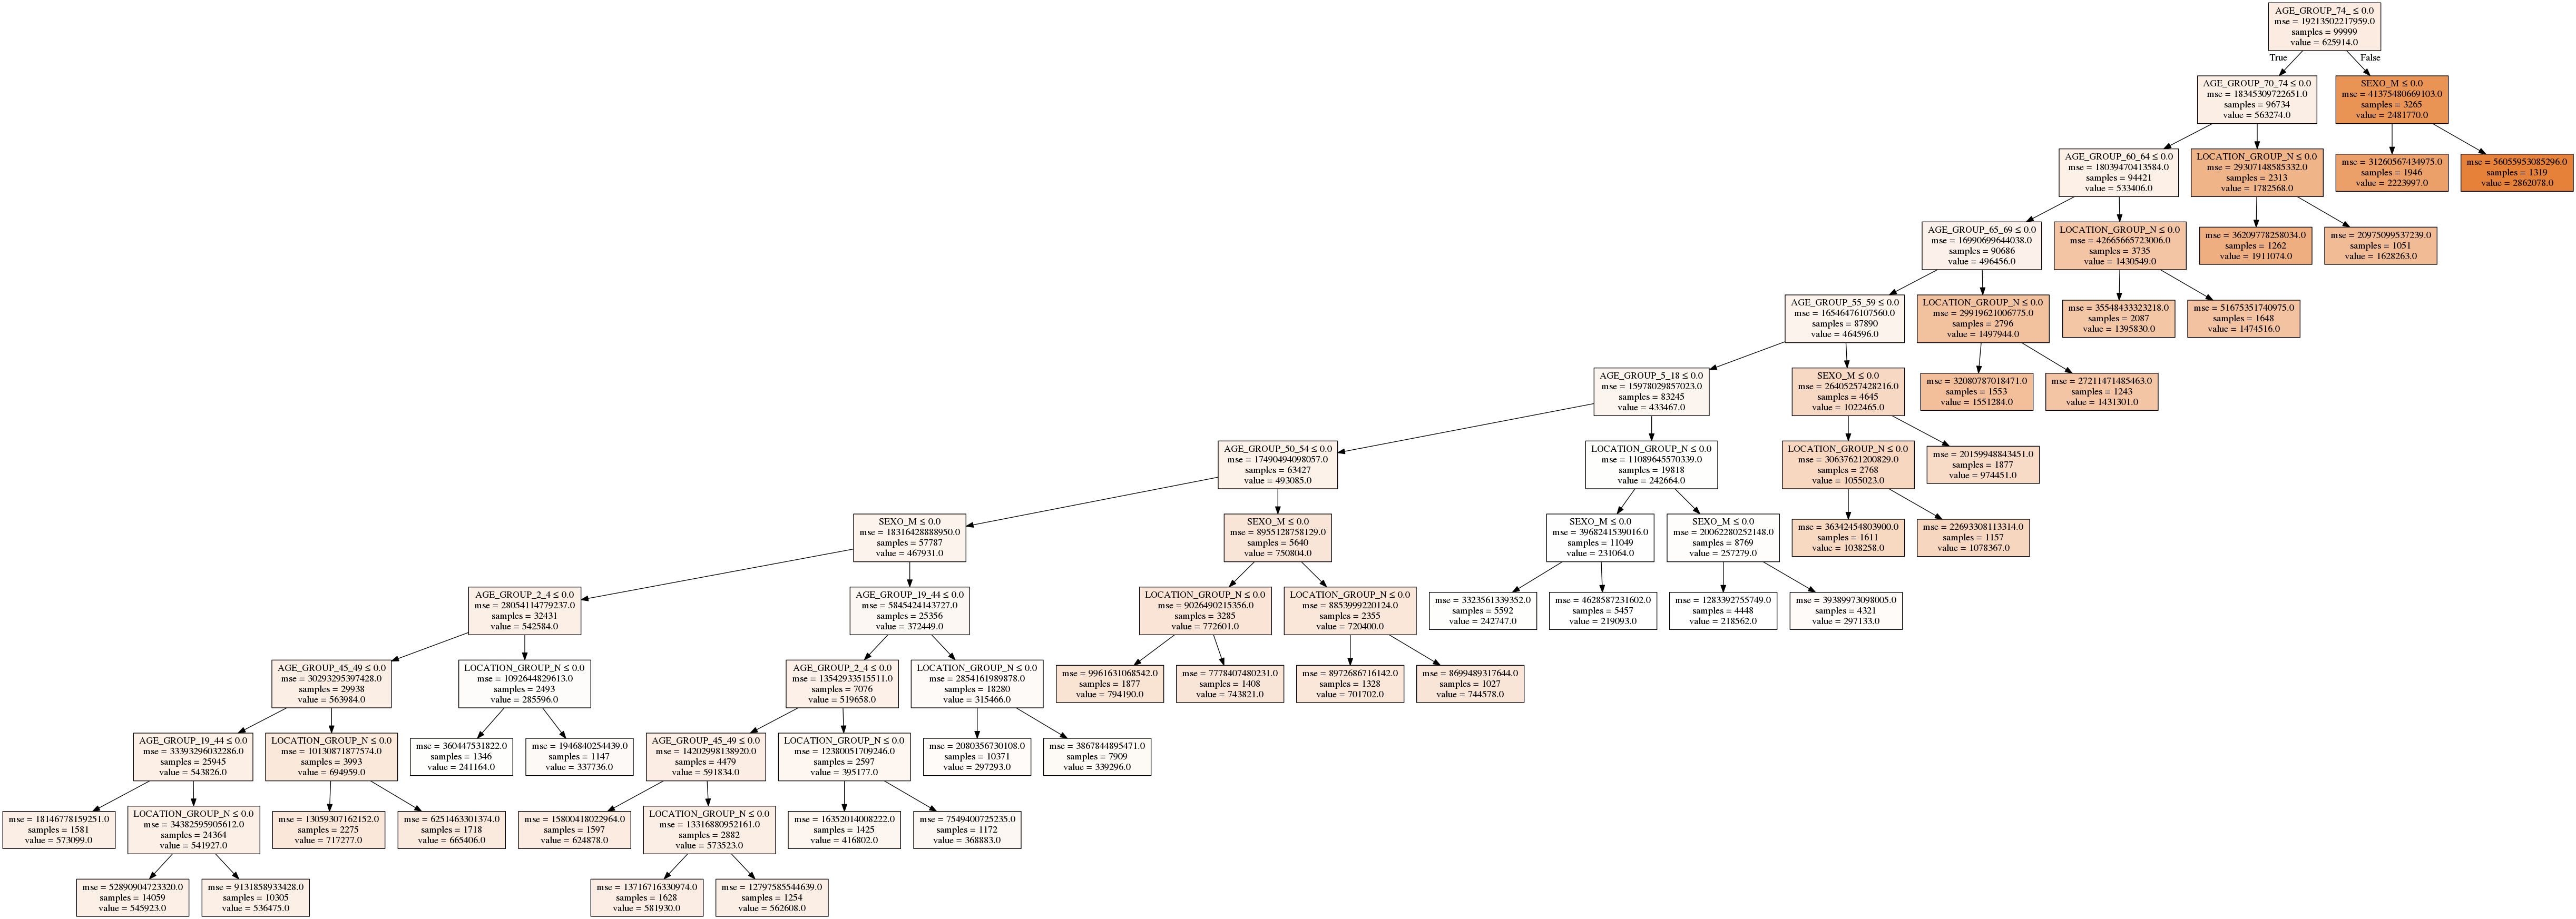

TREE REGRESSION MAE UPPER -10431197.035608685
TREE REGRESSION MAE LOWER 309883.26552022423


In [24]:
reg_tree = DecisionTreeRegressor(min_samples_leaf=1000)
reg_tree = reg_tree.fit(df_salud[features].values,df_salud[target].values)
plot_tree(reg_tree)

upper = df_salud[df_salud['VALOR_TOT_2011'] > (3*10**6)]
y_pred_upper = reg_tree.predict(upper[features])
print('TREE REGRESSION MAE UPPER',(y_pred_upper-upper['VALOR_TOT_2011']).mean())

lower = df_salud[df_salud['VALOR_TOT_2011'] <= (3*10**6)]
y_pred_lower = reg_tree.predict(lower[features])
print('TREE REGRESSION MAE LOWER',(y_pred_lower-lower['VALOR_TOT_2011']).mean())

In [25]:
# Feature space
# One reference category is excluded for each dummy group
features = ['SEXO_M',
            'AGE_GROUP_2_4',
            'AGE_GROUP_5_18',
            'AGE_GROUP_19_44',
            'AGE_GROUP_45_49',
            'AGE_GROUP_50_54',
            'AGE_GROUP_55_59',
            'AGE_GROUP_60_64',
            'AGE_GROUP_65_69',
            'AGE_GROUP_70_74',
            'AGE_GROUP_74_',
            'LOCATION_GROUP_N',
            'LOCATION_GROUP_Z',
            'DIAG_1_C_2010',
            'DIAG_1_P_2010',
            'DIAG_1_D_2010',]

# Target space
target = ['VALOR_TOT_2011']

reg = DecisionTreeRegressor(min_samples_leaf=100)
neg_mae = cross_val_score(estimator=reg,X=df_salud[features],y=df_salud[target],cv=10,scoring='neg_mean_absolute_error')
print('TREE REGRESSION MAE',-1*neg_mae.mean())

TREE REGRESSION MAE 758003.4375539062


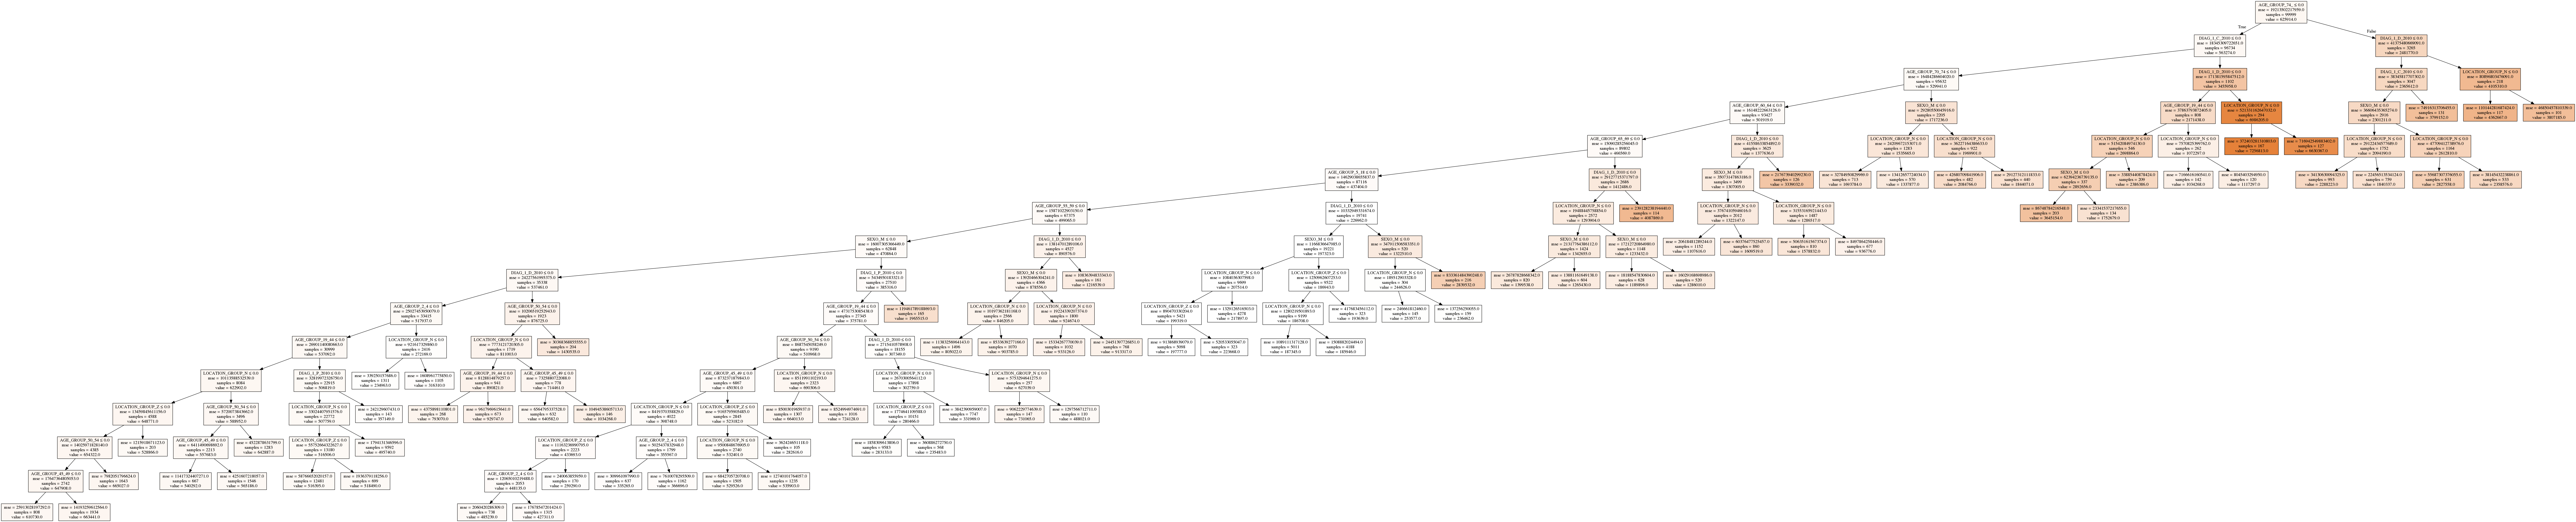

TREE REGRESSION MAE UPPER -10155599.65311588
TREE REGRESSION MAE LOWER 301695.9964499384


In [26]:
reg_tree = DecisionTreeRegressor(min_samples_leaf=100)
reg_tree = reg_tree.fit(df_salud[features].values,df_salud[target].values)
plot_tree(reg_tree)

upper = df_salud.loc[df_salud['VALOR_TOT_2011'] > (3*10**6)]
y_pred_upper = reg_tree.predict(upper[features])
print('TREE REGRESSION MAE UPPER',(y_pred_upper-upper['VALOR_TOT_2011']).mean())

lower = df_salud.loc[df_salud['VALOR_TOT_2011'] <= (3*10**6)]
y_pred_lower = reg_tree.predict(lower[features])
print('TREE REGRESSION MAE LOWER',(y_pred_lower-lower['VALOR_TOT_2011']).mean())